In [1]:
import sys
sys.path.append("../../")
import numpy as np
import xgboost as xgb
from DanceProj1.XGB_Genreclass import get_XGBclassifier
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data
import matplotlib.pyplot as plt

This notebook is for inspecting the model. get_XGBclassifier essentially does everything from Notebook 02. 

In [2]:
xgb_mod, X_test, y_test, y_pred, y_proba_pred, yprobdf = get_XGBclassifier()

In [3]:
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.102943,0.155679,0.018298,0.104901,0.062415,0.314966,0.030880,0.015018,0.108549,0.086350,1565,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.033570,0.023562,0.024930,0.086090,0.024906,0.672489,0.022066,0.014703,0.074809,0.022876,1591,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.052050,0.021557,0.007512,0.013277,0.032721,0.623952,0.007026,0.012608,0.022553,0.206744,1571,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.906113,0.008100,0.032384,0.011848,0.004489,0.014854,0.006389,0.001265,0.009278,0.005281,1579,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.972158,0.001367,0.001130,0.000693,0.000797,0.017793,0.000849,0.000711,0.002043,0.002459,1563,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [4]:
#split into dfs by genre
BJazzdf = yprobdf[yprobdf['True_Label']=='Ballet Jazz']
Breakdf = yprobdf[yprobdf['True_Label']=='Break']
Housedf = yprobdf[yprobdf['True_Label']=='House']
Krumpdf = yprobdf[yprobdf['True_Label']=='Krump']
LAhopdf = yprobdf[yprobdf['True_Label']=='LAhop']
Lockdf = yprobdf[yprobdf['True_Label']=='Lock']
Midhopdf = yprobdf[yprobdf['True_Label']=='Midhop']
Popdf = yprobdf[yprobdf['True_Label']=='Pop']
SJazzdf = yprobdf[yprobdf['True_Label']=='Street Jazz']
Waackdf = yprobdf[yprobdf['True_Label']=='Waack']

Genredfs = [BJazzdf, Breakdf, Housedf, Krumpdf, LAhopdf, Lockdf, Midhopdf, Popdf, SJazzdf, Waackdf]

In [5]:
#inspect the misclassified Ballet Jazz pieces
yprob_misBJazz = BJazzdf[BJazzdf['Ballet Jazz']<0.5]
yprob_misBJazz

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.102943,0.155679,0.018298,0.104901,0.062415,0.314966,0.030880,0.015018,0.108549,0.086350,1565,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.033570,0.023562,0.024930,0.086090,0.024906,0.672489,0.022066,0.014703,0.074809,0.022876,1591,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.052050,0.021557,0.007512,0.013277,0.032721,0.623952,0.007026,0.012608,0.022553,0.206744,1571,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
6,0.079782,0.294858,0.144204,0.030350,0.121908,0.044607,0.041026,0.014055,0.115876,0.113333,1567,Ballet Jazz,gJB_sFM_cAll_d08_mJB0_ch08


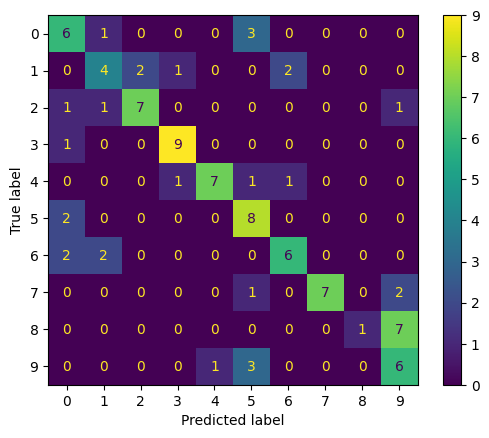

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_test, y_test)

<Figure size 1000x1000 with 0 Axes>

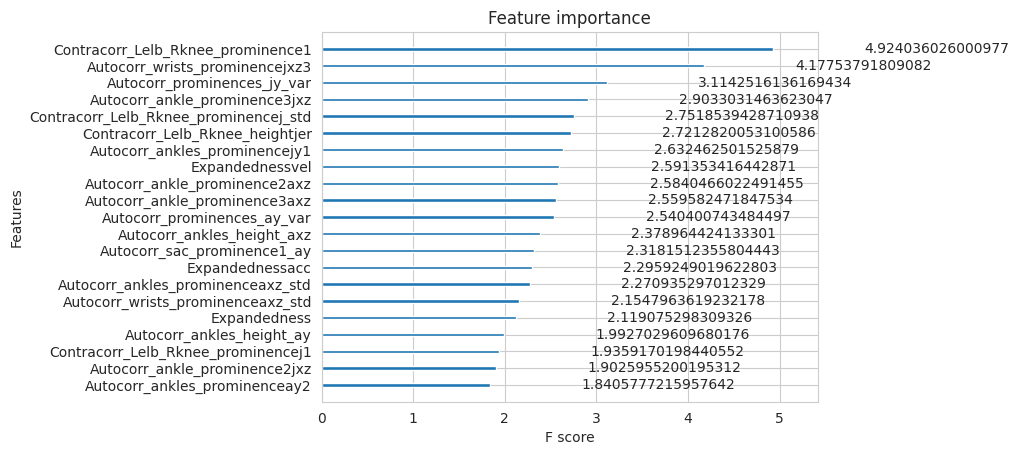

In [10]:
#check features importance of top 21 features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='gain')
plt.show()

#note feature importance order seems a bit sensitive to testset randomization

In [6]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dataFM['Ballet Jazz'][0][-1]

'gJB_sFM_cAll_d07_mJB3_ch04'

In [7]:
#Create Dance object for Ballet Jazz pieces that were correctly, and incorrectly classified
HitBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

print(len(HitBJazz)) 

#get Dance object for all Ballet Jazz pieces that were misclassified
missBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in yprob_misBJazz.id.values:
        print(data[-1])
        missBJazz.append(Dance(data[0], dt=1/60))
        missBJazz[-1].get_features()

print(len(missBJazz))
print(missBJazz[0])
print(missBJazz[0].acceleration.shape)

6
gJB_sFM_cAll_d07_mJB4_ch05
gJB_sFM_cAll_d08_mJB0_ch08
gJB_sFM_cAll_d09_mJB3_ch18
gJB_sFM_cAll_d09_mJB2_ch17
4
(15, 1919, 3)


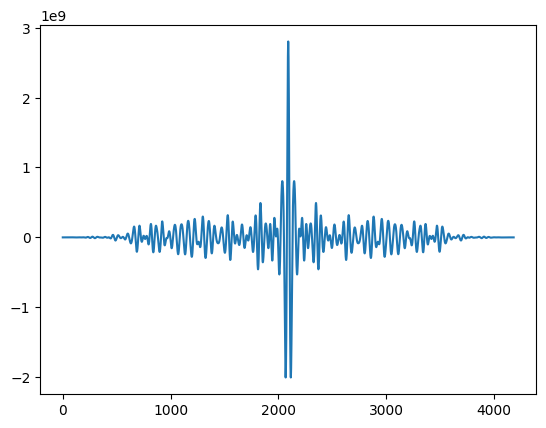

In [17]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first misclassified Ballet Jazz piece
anklecorry_jer = (np.correlate(missBJazz[0].jerk[13][:,1], missBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(missBJazz[0].jerk[14][:,1], missBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

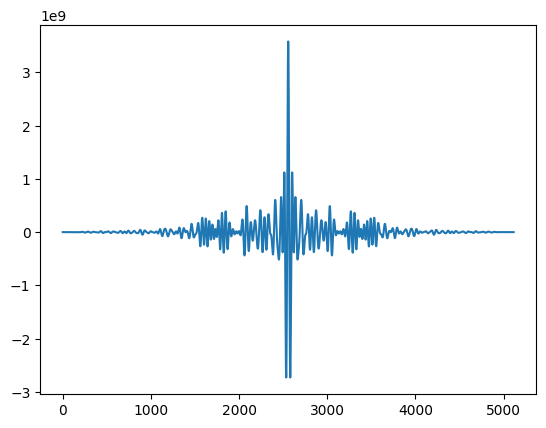

In [20]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first correctly classified Ballet Jazz piece
anklecorry_jer = (np.correlate(HitBJazz[0].jerk[13][:,1], HitBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(HitBJazz[0].jerk[14][:,1], HitBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

In [25]:
#look at the features of the misclassified Ballet Jazz pieces
testset.loc[testset.id.isin(yprob_misBJazz.id)]

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1609,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1583,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1579,1016.357632,99.647915,1285.371478,587.623914,5784.954412,2807.437497,2195.687077,1578.601247,1954.705135,6.754464,...,9.035397e+08,7.964862e+08,8.472218e+07,1.002533e+09,1.734618e+09,1.686987e+09,1.495129e+09,1.035124e+08,gJB_sFM_cAll_d08_mJB3_ch11,Ballet Jazz
1587,1048.961981,107.692128,1234.471461,737.767102,5619.424194,3698.488138,9465.520424,-1080.890634,1052.127688,34.725294,...,1.543689e+09,1.448671e+09,5.126360e+07,4.751784e+08,1.018493e+09,8.528029e+08,7.857072e+08,9.783448e+07,gJB_sFM_cAll_d08_mJB1_ch09,Ballet Jazz
